# Table of Contents (Continued from previous notebook..)

[6. Load Data, Variables, Functions, Libraries from previous notebook](#section6)<br>
[7. Feature Multi-Collinearities](#section7)<br>
[8. Preparing Data for Modelling](#section8)<br>
[9. Feature Selection and ML Model Tuning --- Regression](#section9)<br>

# <a id = 'section6'>6. Load Data,Variables,Functions,Libraries from previous notebook</a>

In [19]:
#general purpose libraries...
import os
#print(os.getcwd())
import warnings
warnings.filterwarnings('ignore')
import pickle
from prettytable import PrettyTable
import math
import re
from tqdm import tqdm,tqdm_notebook
import itertools


#data analysis libraries...
import pandas as pd
import numpy as np 
import scipy
from scipy import sparse
from scipy.sparse import hstack



#visualization libraries...
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


#Modelling Libraries....
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer,mean_squared_error,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier,LinearRegression,SGDRegressor
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from xgboost import XGBClassifier,XGBRegressor
from sklearn.feature_selection import SelectKBest,f_regression,RFECV,RFE,SelectFromModel
from sklearn.decomposition import TruncatedSVD


#nlp libraries...
from collections import Counter 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk.stem import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


#Deep Learning Libraries..
#from keras.preprocessing.text import Tokenizer                    
#from keras.preprocessing.sequence import pad_sequences
#from keras.models import Sequential
#from keras import layers
#from keras.layers import Dense
#from keras.layers import LSTM
#from keras.layers.embeddings import Embedding
#from keras.preprocessing import sequence


#Multicollinearity 
from scipy import stats
import scipy.stats as ss
import dython
from dython.nominal import associations

#### Defining RMSE 

In [2]:
def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error((y_true), (y_pred)))

rmse_scorer = make_scorer(rmse_score, greater_is_better=False)

#### Defining RMSLE 

In [3]:
def rmsle_score(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: #check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

rmsle_scorer = make_scorer(rmsle_score, greater_is_better=False)

In [4]:
#with open('df_enhanced.pickle', 'wb') as f:
#    pickle.dump(df, f)


#infile = open('df_enhanced.pickle','rb')
#df = pickle.load(infile)
#infile.close()

# <a id = 'section7'>7. Feature Multi-Collinearities</a>

### References Used ----

####  https://github.com/shakedzy/dython/blob/master/README.md
##### https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

#### Calculate the correlation/strength-of-association of features in data-set with both categorical (eda_tools) and continuous features using:
##### Pearson's R for continuous-continuous cases
##### Correlation Ratio for categorical-continuous cases - https://en.wikipedia.org/wiki/Correlation_ratio
##### Cramer's V or Theil's U for categorical-categorical cases -(Here, we have used Theil's U coefficient) - https://en.wikipedia.org/wiki/Uncertainty_coefficient


In [41]:
df_coll = df[['preprocessed_names',
    'Location','Fuel_Type','Transmission','Owner_Type','Seats_imputation',
             'Kilometers_Driven','engine_imputation','power_imputation','mileage_imputation','age',
             'Price']]

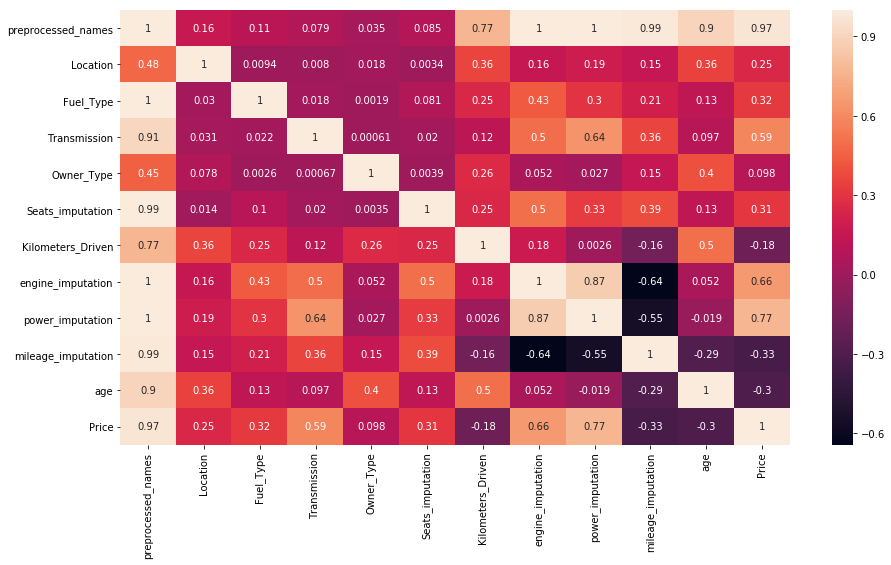

In [42]:
df_coll_matrix = associations(dataset = df_coll, 
             nominal_columns = ['preprocessed_names','Location','Fuel_Type','Transmission','Owner_Type','Seats_imputation'],
            theil_u = True,return_results = True,plot = False)
plt.figure(figsize = (15,8))
sns.heatmap(df_coll_matrix, annot=True)

##### Summary - Engine and Power are co-related (makes common sense) - by a factor of > 0.85

# <a id = 'section8'>8. Preparing Data for Modelling</a>

In [5]:
df_train, df_test = train_test_split(df[['preprocessed_names',
    'Location','Fuel_Type','Transmission','Owner_Type','Seats_imputation',
             'Kilometers_Driven','engine_imputation','power_imputation','mileage_imputation','age',
             'Price']], test_size=0.25)
print(df_train.shape)
print(df_test.shape)

(4508, 12)
(1503, 12)


In [4]:
#with open('df_train_enhanced.pickle', 'wb') as f:
#    pickle.dump(df_train, f)


#infile = open('df_train_enhanced.pickle','rb')
#df_train = pickle.load(infile)
#infile.close()


################################################################################
#with open('df_test_enhanced.pickle', 'wb') as f:
#    pickle.dump(df_test, f)


#infile = open('df_test_enhanced.pickle','rb')
#df_test = pickle.load(infile)
#infile.close()

##### Featurizing 'Names' - BOW

In [5]:
vectorizer = CountVectorizer(ngram_range = (1,4))

train_title_bow = vectorizer.fit_transform(df_train.preprocessed_names.values)
test_title_bow = vectorizer.transform(df_test.preprocessed_names.values)

print("Shape of Train matrix after one hot encodig ",train_title_bow.shape)
print("Shape of Test matrix after one hot encodig ",test_title_bow.shape)

Shape of Train matrix after one hot encodig  (4508, 6657)
Shape of Test matrix after one hot encodig  (1503, 6657)


##### Featurizing 'Location' - OHE

In [6]:
#TRAIN DATA....
vectorizer = CountVectorizer(vocabulary= list(df_train['Location'].unique()), lowercase=False, binary=True)
vectorizer.fit(df_train['Location'].values)
location_one_hot_features = vectorizer.get_feature_names()
train_loc_one_hot = vectorizer.transform(df_train['Location'].values)
print("Shape of Train matrix after one hot encodig ",train_loc_one_hot.shape)


#TEST DATA.....
test_loc_one_hot = vectorizer.transform(df_test['Location'].values)
print("Shape of Test matrix after one hot encodig ",test_loc_one_hot.shape)

Shape of Train matrix after one hot encodig  (4508, 11)
Shape of Test matrix after one hot encodig  (1503, 11)


##### Featurizing ''Fuel Type" - OHE

In [7]:
#TRAIN DATA....
vectorizer = CountVectorizer(vocabulary= list(df_train['Fuel_Type'].unique()), lowercase=False, binary=True)
vectorizer.fit(df_train['Fuel_Type'].values)
fuel_one_hot_features = vectorizer.get_feature_names()
train_fuel_one_hot = vectorizer.transform(df_train['Fuel_Type'].values)
print("Shape of Train matrix after one hot encodig ",train_fuel_one_hot.shape)


#TEST DATA.....
test_fuel_one_hot = vectorizer.transform(df_test['Fuel_Type'].values)
print("Shape of Test matrix after one hot encodig ",test_fuel_one_hot.shape)

Shape of Train matrix after one hot encodig  (4508, 5)
Shape of Test matrix after one hot encodig  (1503, 5)


##### Featurizing ''Transmission"

In [8]:
#TRAIN DATA....
vectorizer = CountVectorizer(vocabulary= list(df_train['Transmission'].unique()), lowercase=False, binary=True)
vectorizer.fit(df_train['Transmission'].values)
transmission_one_hot_features = vectorizer.get_feature_names()
train_transmission_one_hot = vectorizer.transform(df_train['Transmission'].values)
print("Shape of Train matrix after one hot encodig ",train_transmission_one_hot.shape)


#TEST DATA.....
test_transmission_one_hot = vectorizer.transform(df_test['Transmission'].values)
print("Shape of Test matrix after one hot encodig ",test_transmission_one_hot.shape)

Shape of Train matrix after one hot encodig  (4508, 2)
Shape of Test matrix after one hot encodig  (1503, 2)


##### Featurizing ''Owner Type"

In [9]:
#TRAIN DATA....
vectorizer = CountVectorizer(vocabulary= list(df_train['Owner_Type'].unique()), lowercase=False, binary=True)
vectorizer.fit(df_train['Owner_Type'].values)
owner_one_hot_features = vectorizer.get_feature_names()
train_owner_one_hot = vectorizer.transform(df_train['Owner_Type'].values)
print("Shape of Train matrix after one hot encodig ",train_owner_one_hot.shape)


#TEST DATA.....
test_owner_one_hot = vectorizer.transform(df_test['Owner_Type'].values)
print("Shape of Test matrix after one hot encodig ",test_owner_one_hot.shape)

Shape of Train matrix after one hot encodig  (4508, 4)
Shape of Test matrix after one hot encodig  (1503, 4)


##### Featurizing ''Seats"

In [10]:
#TRAIN DATA....
vectorizer = CountVectorizer(vocabulary= list(df_train['Seats_imputation'].unique()), lowercase=False, binary=True)
vectorizer.fit(df_train['Seats_imputation'].values)
seats_one_hot_features = vectorizer.get_feature_names()
train_seats_one_hot = vectorizer.transform(df_train['Seats_imputation'].values)
print("Shape of Train matrix after one hot encodig ",train_seats_one_hot.shape)


#TEST DATA.....
test_seats_one_hot = vectorizer.transform(df_test['Seats_imputation'].values)
print("Shape of Test matrix after one hot encodig ",test_seats_one_hot.shape)

Shape of Train matrix after one hot encodig  (4508, 8)
Shape of Test matrix after one hot encodig  (1503, 8)


##### Featurizing ''kms_driven"

In [11]:
#TRAIN DATA....

train_kms_scalar = StandardScaler()
train_kms_scalar.fit(df_train['Kilometers_Driven'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {train_kms_scalar.mean_[0]}, Standard deviation : {np.sqrt(train_kms_scalar.var_[0])}")
train_kms_standardized = train_kms_scalar.transform(df_train['Kilometers_Driven'].values.reshape(-1, 1))


#TEST DATA....
test_kms_scalar = StandardScaler()
test_kms_scalar.fit(df_test['Kilometers_Driven'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {test_kms_scalar.mean_[0]}, Standard deviation : {np.sqrt(test_kms_scalar.var_[0])}")
test_kms_standardized = test_kms_scalar.transform(df_test['Kilometers_Driven'].values.reshape(-1, 1))

Mean : 56592.3123336291, Standard deviation : 33369.96111463753
Mean : 58621.53493013972, Standard deviation : 34334.01795323386


##### Featurizing ''engine_imputation"

In [12]:
#TRAIN DATA....

train_engine_scalar = StandardScaler()
train_engine_scalar.fit(df_train['engine_imputation'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {train_engine_scalar.mean_[0]}, Standard deviation : {np.sqrt(train_engine_scalar.var_[0])}")
train_engine_standardized = train_engine_scalar.transform(df_train['engine_imputation'].values.reshape(-1, 1))


#TEST DATA....
test_engine_scalar = StandardScaler()
test_engine_scalar.fit(df_test['engine_imputation'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {test_engine_scalar.mean_[0]}, Standard deviation : {np.sqrt(test_engine_scalar.var_[0])}")
test_engine_standardized = test_engine_scalar.transform(df_test['engine_imputation'].values.reshape(-1, 1))

Mean : 1616.0942201126402, Standard deviation : 596.3439384524655
Mean : 1636.2488820963374, Standard deviation : 608.8142341934248


##### Featurizing ''power_imputation"

In [13]:
#TRAIN DATA....

train_power_scalar = StandardScaler()
train_power_scalar.fit(df_train['power_imputation'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {train_power_scalar.mean_[0]}, Standard deviation : {np.sqrt(train_power_scalar.var_[0])}")
train_power_standardized = train_power_scalar.transform(df_train['power_imputation'].values.reshape(-1, 1))


#TEST DATA....
test_power_scalar = StandardScaler()
test_power_scalar.fit(df_test['power_imputation'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {test_power_scalar.mean_[0]}, Standard deviation : {np.sqrt(test_power_scalar.var_[0])}")
test_power_standardized = test_power_scalar.transform(df_test['power_imputation'].values.reshape(-1, 1))

Mean : 112.84731415966195, Standard deviation : 53.65003955913976
Mean : 114.281666134408, Standard deviation : 54.28243286927456


##### Featurizing ''mileage_imputation"

In [14]:
#TRAIN DATA....

train_mileage_scalar = StandardScaler()
train_mileage_scalar.fit(df_train['mileage_imputation'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {train_mileage_scalar.mean_[0]}, Standard deviation : {np.sqrt(train_mileage_scalar.var_[0])}")
train_mileage_standardized = train_mileage_scalar.transform(df_train['mileage_imputation'].values.reshape(-1, 1))


#TEST DATA....
test_mileage_scalar = StandardScaler()
test_mileage_scalar.fit(df_test['mileage_imputation'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {test_mileage_scalar.mean_[0]}, Standard deviation : {np.sqrt(test_mileage_scalar.var_[0])}")
test_mileage_standardized = test_mileage_scalar.transform(df_test['mileage_imputation'].values.reshape(-1, 1))

Mean : 18.361756293626573, Standard deviation : 4.118499088880693
Mean : 18.22240065085032, Standard deviation : 4.284417246265983


##### Featurizing ''Age"

In [15]:
#TRAIN DATA....

train_age_scalar = StandardScaler()
train_age_scalar.fit(df_train['age'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {train_age_scalar.mean_[0]}, Standard deviation : {np.sqrt(train_age_scalar.var_[0])}")
train_age_standardized = train_age_scalar.transform(df_train['age'].values.reshape(-1, 1))


#TEST DATA....
test_age_scalar = StandardScaler()
test_age_scalar.fit(df_test['age'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {test_age_scalar.mean_[0]}, Standard deviation : {np.sqrt(test_age_scalar.var_[0])}")
test_age_standardized = test_age_scalar.transform(df_test['age'].values.reshape(-1, 1))

Mean : 5.649290150842946, Standard deviation : 3.2814084576513154
Mean : 5.616766467065868, Standard deviation : 3.2352081612049797


##### Creating the concatenated 'Feature_stack'

In [16]:
X_train = sparse.hstack((
                         train_title_bow, #0.97
                         train_loc_one_hot, #0.25
                         train_fuel_one_hot, #0.32
                         train_transmission_one_hot, #0.59
                         train_owner_one_hot, #0.1
                         train_seats_one_hot, #0.31
    
    train_age_standardized, #0.3
    train_kms_standardized, #0.18
    train_mileage_standardized, #0.33
    train_engine_standardized, #0.66
    train_power_standardized #0.77
                        ))
#X_train = sparse.hstack([X_train,train[['age','mileage_amount','engine_amount','power_amount','log_kms','Seats']]])
#X_train = X_train.toarray()
print('X train shape',X_train.shape)

y_train = np.array(df_train['Price'])
print('y train shape',y_train.shape)

#######################################################################################

X_test = sparse.hstack((
                         test_title_bow,
                         test_loc_one_hot,
                         test_fuel_one_hot,
                         test_transmission_one_hot,
                         test_owner_one_hot,
                         test_seats_one_hot,
    
                         test_age_standardized,
                         test_kms_standardized,
                         test_mileage_standardized,
                         test_engine_standardized,
                         test_power_standardized
                        ))
#X_train = sparse.hstack([X_train,train[['age','mileage_amount','engine_amount','power_amount','log_kms','Seats']]])
#X_train = X_train.toarray()
print('X test shape',X_test.shape)

y_test = np.array(df_test['Price'])
print('y test shape',y_test.shape)

X train shape (4508, 6692)
y train shape (4508,)
X test shape (1503, 6692)
y test shape (1503,)


# <a id = 'section9'>9. Feature Selection and ML Model Tuning --- Regression</a>

## 9.1  Regression - All Features

In [ ]:
reg_model = XGBRegressor()

parameters = {'max_depth' : [2,3,5,10],
              'subsample' : [0.5,0.75,0.9,1],
              'colsample_bytree' : [0.5,0.75,0.9,1],
              'lambda' : [0.01,0.1,1,10,100],
             'n_estimators' : [200]}

gs_reg = GridSearchCV(reg_model, 
                      parameters,
                      cv=2,
                      verbose = 100, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)


######################################################################
gs_reg.fit(X_train, y_train)
print("Best score ",-gs_reg.best_score_)
print("Best params  ",gs_reg.best_params_)


######################################################################
my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(X_test)
print("Test RMSE is ",rmse_score(y_test, y_predicted))
print("Test RMSLE is ",rmsle_score(y_test, y_predicted))

## 9.2  Regression (removing 'engine' feature - 0.87 co-related to 'power')

In [ ]:
reg_model = RandomForestRegressor()

parameters = {'max_depth' : [2,5,10,20,50,None],
              'max_features' : ["auto",'sqrt','log2'],
             'n_estimators' : [50,100,200]}

gs_reg = GridSearchCV(reg_model, 
                      parameters,
                      cv=2,
                      verbose = 100, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)


######################################################################
gs_reg.fit(X_train, y_train)
print("Best score ",-gs_reg.best_score_)
print("Best params  ",gs_reg.best_params_)


######################################################################
my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(X_test)
print("Test RMSE is ",rmse_score(y_test, y_predicted))
print("Test RMSLE is ",rmsle_score(y_test, y_predicted))

## 9.3  Regression- (keep features with collinearity > 0.5)

In [52]:
reg_model = RandomForestRegressor()

parameters = {'max_depth' : [2,5,10,20,50,None],
              'max_features' : ["auto",'sqrt','log2'],
             'n_estimators' : [50,100,200]}

gs_reg = GridSearchCV(reg_model, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)


######################################################################
gs_reg.fit(X_train, y_train)
print("Best score ",-gs_reg.best_score_)
print("Best params  ",gs_reg.best_params_)


######################################################################
my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(X_test)
print("Test RMSE is ",rmse_score(y_test, y_predicted))
print("Test RMSLE is ",rmsle_score(y_test, y_predicted))

Best score  5.062687034957638
Best params   {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 50}
Test RMSE is  5.265451641718717
Test RMSLE is  0.3163353257530252


## 9.4  Regression- (keep features with collinearity > 0.3)

In [25]:
reg_model = DecisionTreeRegressor()

parameters = {'max_depth' : [2,5,10,20,50,None],
              'max_features' : ["auto",'sqrt','log2']}

gs_reg = GridSearchCV(reg_model, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)


######################################################################
gs_reg.fit(X_train, y_train)
print("Best score ",-gs_reg.best_score_)
print("Best params  ",gs_reg.best_params_)


######################################################################
my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(X_test)
print("Test RMSE is ",rmse_score(y_test, y_predicted))
print("Test RMSLE is ",rmsle_score(y_test, y_predicted))

Best score  4.578645275076484
Best params   {'max_depth': 10, 'max_features': 'auto'}
Test RMSE is  5.115926857679349
Test RMSLE is  0.2833858456853274


## 9.5  Regression- (Select 'K' Best Features) - Find 'K' using Cross Validation

In [64]:
k_vals = [500,1000,2000,2500,3000,3500,4000,4500,5000,5500,6000]
rmse_vals = []


for k in tqdm_notebook(k_vals):
    print("ITerating for k = "+str(k))
    
    selk = SelectKBest(f_regression, k = k)
    X_train_new = selk.fit_transform(X_train,y_train)
    X_test_new = selk.transform(X_test)

    #print('X train new shape ',X_train_new.shape)
    #print('X test new shape ',X_test_new.shape)

    reg_model = RandomForestRegressor()

    parameters = {'max_depth' : [2,5,10,20,50,None],
                  'max_features' : ["auto",'sqrt','log2'],
                 'n_estimators' : [50,100,200]}

    gs_reg = GridSearchCV(reg_model, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)


    ######################################################################
    gs_reg.fit(X_train_new, y_train)
    #print("Best score ",-gs_reg.best_score_)
    #print("Best params  ",gs_reg.best_params_)


    ######################################################################
    my_model = gs_reg.best_estimator_
    y_predicted = my_model.predict(X_test_new)
    print("Test RMSE is ",rmse_score(y_test, y_predicted))
    print("Test RMSLE is ",rmsle_score(y_test, y_predicted))
    rmse_vals.append(rmse_score(y_test, y_predicted))

ITerating for k = 500
Test RMSE is  4.035896192677157
Test RMSLE is  0.22085700881789191
ITerating for k = 1000
Test RMSE is  4.0727418252700955
Test RMSLE is  0.21543351222028875
ITerating for k = 2000
Test RMSE is  3.931411203259806
Test RMSLE is  0.20192548499976834
ITerating for k = 2500
Test RMSE is  3.9074524878143366
Test RMSLE is  0.20249454985261947
ITerating for k = 3000
Test RMSE is  3.926111581088103
Test RMSLE is  0.20142657185094165
ITerating for k = 3500
Test RMSE is  3.866878114469886
Test RMSLE is  0.19848994972007533
ITerating for k = 4000
Test RMSE is  3.9043420345179913
Test RMSLE is  0.19990790539703288
ITerating for k = 4500
Test RMSE is  3.9552624542441945
Test RMSLE is  0.20096768174605428
ITerating for k = 5000
Test RMSE is  3.946788515149406
Test RMSLE is  0.1992549740553577
ITerating for k = 5500
Test RMSE is  3.85488509980715
Test RMSLE is  0.19712535259945932
ITerating for k = 6000
Test RMSE is  3.8907218549373415
Test RMSLE is  0.19786907609236543


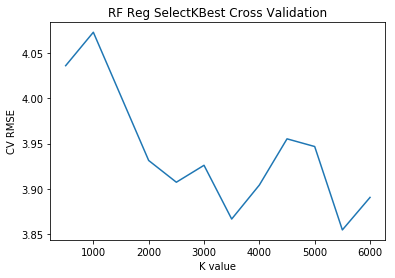

In [65]:
plt.plot(k_vals,rmse_vals)
plt.title('RF Reg SelectKBest Cross Validation')
plt.xlabel('K value')
plt.ylabel('CV RMSE')
plt.savefig('rf_selkbest_plot.png')

## 9.6  Regression- (PCA/TSVD) - Reduce dimensionality upto 95% variance preserved

In [ ]:
# Program to find the optimal number of components for Truncated SVD
n_comp = [200,500,1000,2500,3000] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in tqdm_notebook(n_comp):
    print('Iterating for ncomp = '+str(x))
    tsvd = TruncatedSVD(n_components=x)
    tsvd.fit(X_train)
    explained.append(tsvd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,tsvd.explained_variance_ratio_.sum()))
#plt.show()

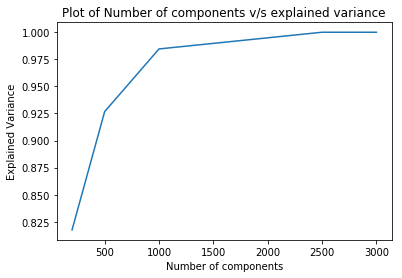

In [33]:
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.savefig('tsvd_ncomps_plot_6k_feats.png')

##### TSVD summary - We can select 1000 as n_comps here since it preserves >95% variance = 98% variance 

In [ ]:
tsvd = TruncatedSVD(n_components=1000)
X_train_new = tsvd.fit_transform(X_train)
X_test_new = tsvd.transform(X_test)
print('TSVD fit done')
#############################################################################3

reg_model = RandomForestRegressor()

parameters = {'max_depth' : [2,5,10,20,50,None],
                  'max_features' : ["auto",'sqrt','log2'],
                 'n_estimators' : [50,100,200]}

gs_reg = GridSearchCV(reg_model, 
                      parameters,
                      cv=2,
                      verbose = 100, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)


######################################################################
gs_reg.fit(X_train_new, y_train)
print("Best score ",-gs_reg.best_score_)
print("Best params  ",gs_reg.best_params_)


######################################################################
my_model = gs_reg.best_estimator_
y_predicted = my_model.predict(X_test_new)
print("Test RMSE is ",rmse_score(y_test, y_predicted))
print("Test RMSLE is ",rmsle_score(y_test, y_predicted))


## 9.7  Regression- (Recursive Feature Elimination)

In [71]:
n_feats = [500,1000,1500,2000,2500,3000,3500,4000,4500,5000]
cv_rmse = []

for x in tqdm_notebook(n_feats):
    selector = RFE(SGDRegressor(), x, step=0.1,verbose = 0)
    selector = selector.fit(X_train, y_train)
    
    X_train_new = selector.transform(X_train)
    X_test_new = selector.transform(X_test)
    print('Selector fit done')
    #############################################################################3

    reg_model = RandomForestRegressor()

    parameters = {'max_depth' : [2,5,10,20,50,None],
                      'max_features' : ["auto",'sqrt','log2'],
                     'n_estimators' : [50,100,200]}

    gs_reg = GridSearchCV(reg_model, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)


    ######################################################################
    gs_reg.fit(X_train_new, y_train)
    #print("Best score ",-gs_reg.best_score_)
    #print("Best params  ",gs_reg.best_params_)


    ######################################################################
    my_model = gs_reg.best_estimator_
    y_predicted = my_model.predict(X_test_new)
    print("Test RMSE is ",rmse_score(y_test, y_predicted))
    print("Test RMSLE is ",rmsle_score(y_test, y_predicted))
    cv_rmse.append(rmse_score(y_test, y_predicted))  

Selector fit done
Test RMSE is  4.071271580645835
Test RMSLE is  0.224841417636947
Selector fit done
Test RMSE is  4.002090037635728
Test RMSLE is  0.20704310913530063
Selector fit done
Test RMSE is  3.8890992574274663
Test RMSLE is  0.20416982198251465
Selector fit done
Test RMSE is  3.851292660449412
Test RMSLE is  0.20100562293164037
Selector fit done
Test RMSE is  3.8947393803082564
Test RMSLE is  0.19883338022259697
Selector fit done
Test RMSE is  4.022651940073974
Test RMSLE is  0.20000314102531405
Selector fit done
Test RMSE is  3.937783477988169
Test RMSLE is  0.20108257249600156
Selector fit done
Test RMSE is  3.948828875400024
Test RMSLE is  0.19877443590424562
Selector fit done
Test RMSE is  3.8670324012970116
Test RMSLE is  0.19834196207996418
Selector fit done
Test RMSE is  3.8787827743747356
Test RMSLE is  0.19772568701944734


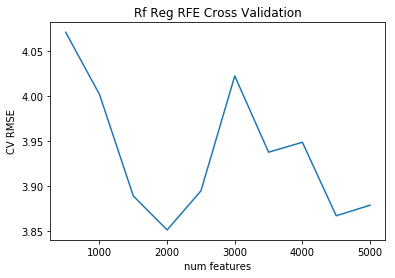

In [72]:
plt.plot(n_feats,cv_rmse)
plt.title('Rf Reg RFE Cross Validation')
plt.xlabel('num features')
plt.ylabel('CV RMSE')
plt.savefig('rf_reg_rfecv_plot.png')

## 9.8  Regression- (Lasso - 'L1' Based Feature Selection)

In [74]:
C_values = [0.0001,0.001,0.01,0.1,1]
cv_rmse = []

for x in tqdm_notebook(C_values):
    selector = SelectFromModel(SGDRegressor(penalty = 'l1',alpha = x))
    selector = selector.fit(X_train, y_train)
    
    
    X_train_new = selector.transform(X_train)
    X_test_new = selector.transform(X_test)
    print('Shape of train data for aplha = ' + str(x) + ' is '+ str(X_train_new.shape))
    print('Selector fit done')
    #############################################################################3

    reg_model = RandomForestRegressor()

    parameters = {'max_depth' : [2,5,10,20,50,None],
                      'max_features' : ["auto",'sqrt','log2'],
                         'n_estimators' : [50,100,200]}
    
    gs_reg = GridSearchCV(reg_model, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)


    ######################################################################
    gs_reg.fit(X_train_new, y_train)
    #print("Best score ",-gs_reg.best_score_)
    #print("Best params  ",gs_reg.best_params_)


    ######################################################################
    my_model = gs_reg.best_estimator_
    y_predicted = my_model.predict(X_test_new)
    print("Test RMSE is ",rmse_score(y_test, y_predicted))
    print("Test RMSLE is ",rmsle_score(y_test, y_predicted))
    cv_rmse.append(rmse_score(y_test, y_predicted))

Shape of train data for aplha = 0.0001 is (4508, 5913)
Selector fit done
Test RMSE is  3.9412094001989675
Test RMSLE is  0.19924639998857271
Shape of train data for aplha = 0.001 is (4508, 2446)
Selector fit done
Test RMSE is  3.935587744910842
Test RMSLE is  0.20009351372596004
Shape of train data for aplha = 0.01 is (4508, 330)
Selector fit done
Test RMSE is  3.9061119784372393
Test RMSLE is  0.20304897556689114
Shape of train data for aplha = 0.1 is (4508, 27)
Selector fit done
Test RMSE is  4.084537598388127
Test RMSLE is  0.22729903502283486
Shape of train data for aplha = 1 is (4508, 6)
Selector fit done
Test RMSE is  4.977296619209576
Test RMSLE is  0.2885894493720628


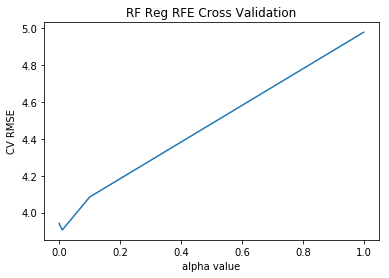

In [75]:
plt.plot(C_values,cv_rmse)
plt.title('RF Reg RFE Cross Validation')
plt.xlabel('alpha value')
plt.ylabel('CV RMSE')
plt.savefig('rf_reg_lasso_feat_selection_plot.png')

## 9.9  Regression- (Trees Based Feature Selection)

In [77]:
n_est = [50,100,250,500]
cv_rmse = []

for x in tqdm_notebook(n_est):
    sel_reg = ExtraTreesRegressor(n_estimators = x)
    sel_reg.fit(X_train,y_train)
    
    model = SelectFromModel(sel_reg, prefit=True)
    #selector = selector.fit(X_train, y_train)
    
    
    X_train_new = model.transform(X_train)
    X_test_new = model.transform(X_test)
    print('Shape of train data for num est = ' + str(x) + ' is '+ str(X_train_new.shape))
    print('Selector fit done')
    #############################################################################3

    reg_model = RandomForestRegressor()

    parameters = {'max_depth' : [2,5,10,20,50,None],
                      'max_features' : ["auto",'sqrt','log2'],
                         'n_estimators' : [50,100,200]}

    gs_reg = GridSearchCV(reg_model, 
                      parameters,
                      cv=2,
                      verbose = 0, 
                      scoring  = rmse_scorer,
                      n_jobs = -2)


    ######################################################################
    gs_reg.fit(X_train_new, y_train)
    #print("Best score ",-gs_reg.best_score_)
    #print("Best params  ",gs_reg.best_params_)


    ######################################################################
    my_model = gs_reg.best_estimator_
    y_predicted = my_model.predict(X_test_new)
    print("Test RMSE is ",rmse_score(y_test, y_predicted))
    print("Test RMSLE is ",rmsle_score(y_test, y_predicted))
    cv_rmse.append(rmse_score(y_test, y_predicted))
    

Shape of train data for num est = 50 is (4508, 221)
Selector fit done
Test RMSE is  3.933305884770404
Test RMSLE is  0.20864162766511996
Shape of train data for num est = 100 is (4508, 228)
Selector fit done
Test RMSE is  3.891832503579911
Test RMSLE is  0.20554946623688763
Shape of train data for num est = 250 is (4508, 218)
Selector fit done
Test RMSE is  3.9851245978697163
Test RMSLE is  0.21118551908287714
Shape of train data for num est = 500 is (4508, 222)
Selector fit done
Test RMSE is  3.90297211629254
Test RMSLE is  0.20925435541266305


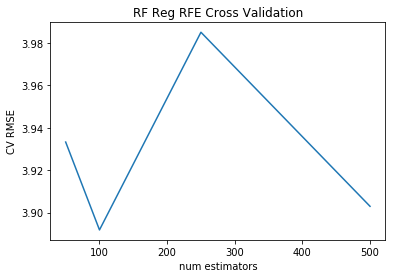

In [78]:
plt.plot(n_est,cv_rmse)
plt.title('RF Reg RFE Cross Validation')
plt.xlabel('num estimators')
plt.ylabel('CV RMSE')
plt.savefig('rf_reg_extratrees_feat_selection_plot.png')

## 9.10  Regression Model Feature Selection Experiments - Summary

In [17]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["S:No.","Linear Regression - Feature Engg","RMSE","RMSLE"]

###################################################

x.add_row([1,"All Feats","4.1**",0.29])
x.add_row([2,"remove engine feature",4.12,0.28])
x.add_row([3,"abs(feats with collinearity) > 0.5",4.82,0.30])
x.add_row([4,"abs(feats with collinearity) > 0.3",4.20,0.28])
x.add_row([5,"SelectKBest(CV) , K= 6000",4.16,0.28])
x.add_row([6,"Trunc SVD, ncomps  = 1000",4.18,0.30])
x.add_row([7,"Recursive Feat Elim(CV) feats = 4000", "4.10**",0.29])
x.add_row([8,"Lasso Based Feat Elim(CV) alpha = 0.0001 feats = 5906", "4.11**",0.29])
x.add_row([9,"Extra Trees Feat Elim(CV) num_est = 50, feats = 237", 4.7,0.31])



print(x)

+-------+-------------------------------------------------------+--------+-------+
| S:No. |            Linear Regression - Feature Engg           |  RMSE  | RMSLE |
+-------+-------------------------------------------------------+--------+-------+
|   1   |                       All Feats                       | 4.1**  |  0.29 |
|   2   |                 remove engine feature                 |  4.12  |  0.28 |
|   3   |           abs(feats with collinearity) > 0.5          |  4.82  |  0.3  |
|   4   |           abs(feats with collinearity) > 0.3          |  4.2   |  0.28 |
|   5   |               SelectKBest(CV) , K= 6000               |  4.16  |  0.28 |
|   6   |               Trunc SVD, ncomps  = 1000               |  4.18  |  0.3  |
|   7   |          Recursive Feat Elim(CV) feats = 4000         | 4.10** |  0.29 |
|   8   | Lasso Based Feat Elim(CV) alpha = 0.0001 feats = 5906 | 4.11** |  0.29 |
|   9   |  Extra Trees Feat Elim(CV) num_est = 50, feats = 237  |  4.7   |  0.31 |
+---

In [39]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["S:No.","Decision Tree Regression - Feature Engg","RMSE","RMSLE"]

###################################################

x.add_row([1,"All Feats",5.07,0.27])
x.add_row([2,"remove engine feature","4.54**",0.26])
x.add_row([3,"abs(feats with collinearity) > 0.5",6.38,0.36])
x.add_row([4,"abs(feats with collinearity) > 0.3",5.11,0.28])
x.add_row([5,"SelectKBest(CV) , K= 3500",4.97,0.27])
x.add_row([6,"Trunc SVD, ncomps  = 1000",5.79,0.35])
x.add_row([7,"Recursive Feat Elim(CV) feats = 1000", "4.64**",0.26])
x.add_row([8,"Lasso Based Feat Elim(CV) alpha = 0.001 feats = 2294", 4.98,0.28])
x.add_row([9,"Extra Trees Feat Elim(CV) num_est = 50, feats = 100", 5.03,0.29])



print(x)

+-------+------------------------------------------------------+--------+-------+
| S:No. |       Decision Tree Regression - Feature Engg        |  RMSE  | RMSLE |
+-------+------------------------------------------------------+--------+-------+
|   1   |                      All Feats                       |  5.07  |  0.27 |
|   2   |                remove engine feature                 | 4.54** |  0.26 |
|   3   |          abs(feats with collinearity) > 0.5          |  6.38  |  0.36 |
|   4   |          abs(feats with collinearity) > 0.3          |  5.11  |  0.28 |
|   5   |              SelectKBest(CV) , K= 3500               |  4.97  |  0.27 |
|   6   |              Trunc SVD, ncomps  = 1000               |  5.79  |  0.35 |
|   7   |         Recursive Feat Elim(CV) feats = 1000         | 4.64** |  0.26 |
|   8   | Lasso Based Feat Elim(CV) alpha = 0.001 feats = 2294 |  4.98  |  0.28 |
|   9   | Extra Trees Feat Elim(CV) num_est = 50, feats = 100  |  5.03  |  0.29 |
+-------+-------

In [79]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["S:No.","Random Forest Regression - Feature Engg","RMSE","RMSLE"]

###################################################

x.add_row([1,"All Feats",3.84,0.19])
x.add_row([2,"remove engine feature",3.92,0.2])
x.add_row([3,"abs(feats with collinearity) > 0.5",5.26,0.31])
x.add_row([4,"abs(feats with collinearity) > 0.3",4.06,0.20])
x.add_row([5,"SelectKBest(CV) , K= 5500",3.85,0.19])
x.add_row([6,"Trunc SVD, ncomps  = 1000",4,0.21])
x.add_row([7,"Recursive Feat Elim(CV) feats = 2000", 3.85,0.2])
x.add_row([8,"Lasso Based Feat Elim(CV) alpha = 0.001 feats = 2446", 3.93,0.2])
x.add_row([9,"Extra Trees Feat Elim(CV) num_est = 100, feats = 228", 3.89,0.2])



print(x)

+-------+------------------------------------------------------+------+-------+
| S:No. |       Random Forest Regression - Feature Engg        | RMSE | RMSLE |
+-------+------------------------------------------------------+------+-------+
|   1   |                      All Feats                       | 3.84 |  0.19 |
|   2   |                remove engine feature                 | 3.92 |  0.2  |
|   3   |          abs(feats with collinearity) > 0.5          | 5.26 |  0.31 |
|   4   |          abs(feats with collinearity) > 0.3          | 4.06 |  0.2  |
|   5   |              SelectKBest(CV) , K= 5500               | 3.85 |  0.19 |
|   6   |              Trunc SVD, ncomps  = 1000               |  4   |  0.21 |
|   7   |         Recursive Feat Elim(CV) feats = 2000         | 3.85 |  0.2  |
|   8   | Lasso Based Feat Elim(CV) alpha = 0.001 feats = 2446 | 3.93 |  0.2  |
|   9   | Extra Trees Feat Elim(CV) num_est = 100, feats = 228 | 3.89 |  0.2  |
+-------+-------------------------------

In [18]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["S:No.","GBM Regression - Feature Engg","RMSE","RMSLE"]

###################################################

x.add_row([1,"All Feats",3.52,0.18])
#x.add_row([2,"remove engine feature",3.92,0.2])
#x.add_row([3,"abs(feats with collinearity) > 0.5",5.26,0.31])
#x.add_row([4,"abs(feats with collinearity) > 0.3",4.06,0.20])
#x.add_row([5,"SelectKBest(CV) , K= 5500",3.85,0.19])
#x.add_row([6,"Trunc SVD, ncomps  = 1000",4,0.21])
#x.add_row([7,"Recursive Feat Elim(CV) feats = 2000", 3.85,0.2])
#x.add_row([8,"Lasso Based Feat Elim(CV) alpha = 0.001 feats = 2446", 3.93,0.2])
#x.add_row([9,"Extra Trees Feat Elim(CV) num_est = 100, feats = 228", 3.89,0.2])



print(x)

+-------+-------------------------------+------+-------+
| S:No. | GBM Regression - Feature Engg | RMSE | RMSLE |
+-------+-------------------------------+------+-------+
|   1   |           All Feats           | 3.52 |  0.18 |
+-------+-------------------------------+------+-------+


In [26]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["S:No.","XGboost Regression - Feature Engg","RMSE","RMSLE"]

###################################################

x.add_row([1,"All Feats",3.3,0.19])
#x.add_row([2,"remove engine feature",3.92,0.2])
#x.add_row([3,"abs(feats with collinearity) > 0.5",5.26,0.31])
#x.add_row([4,"abs(feats with collinearity) > 0.3",4.06,0.20])
#x.add_row([5,"SelectKBest(CV) , K= 5500",3.85,0.19])
#x.add_row([6,"Trunc SVD, ncomps  = 1000",4,0.21])
#x.add_row([7,"Recursive Feat Elim(CV) feats = 2000", 3.85,0.2])
#x.add_row([8,"Lasso Based Feat Elim(CV) alpha = 0.001 feats = 2446", 3.93,0.2])
#x.add_row([9,"Extra Trees Feat Elim(CV) num_est = 100, feats = 228", 3.89,0.2])



print(x)

+-------+-----------------------------------+------+-------+
| S:No. | XGboost Regression - Feature Engg | RMSE | RMSLE |
+-------+-----------------------------------+------+-------+
|   1   |             All Feats             | 3.3  |  0.19 |
+-------+-----------------------------------+------+-------+
